# Tutorial

[Download This Notebook](https://ross-rotordynamics.github.io/ross-website/_downloads/51a7c8bd4026689b99005339576b2193/tutorial.ipynb)

This is a basic tutorial on how to use ross (rotordynamics open-source software), a Python library for rotordynamic analysis. The majority of this code follows object-oriented coding, which is represented in this
[UML DIAGRAM](https://user-images.githubusercontent.com/32821252/50386686-131c5200-06d3-11e9-9806-f5746295be81.png).  
In the following topics we are going to discuss the most relevant classes for a quick start to use ROSS. 

In [1]:
import ross as rs
from bokeh.io import output_notebook, show
import numpy as np
import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

## Materials

There is a class called Material to hold material's properties, where:

```text
name : str
    Material name.
E : float
    Young's modulus (N/m**2).
G_s : float
    Shear modulus (N/m**2).
rho : float
    Density (N/m**3).
```

Note that, to instatiate a Material class, you only need to give 2 out of the following parameters: 'E', 'G_s' ,'Poisson'.

In [2]:
Steel = rs.Material(name="Steel", rho=7810, E=211e9, G_s=81.2e9)

### Saving a Material

To save an already instantiated Material object, you need to use the following method.

In [3]:
Steel.save_material()

### Loading a Material


To load a material, first of all, use the available_materials() method to check if your material is available in the database, then you should use the Material.use_material('name') method with the name of the material as a parameter.



In [4]:
rs.Material.available_materials()

['AISI4140', 'Steel']

In [5]:
steel = rs.Material.use_material('Steel')

## Element

Element is an abstract class (not directly used in the program), this class is mainly used to organize the code and make it more intuitive. 

- All the classes which derives from Element ends with Element in their respective names.
- Every element is placed in a node, which is the junction of two elements.


## ShaftElement

There are two methods that you could use to model this element:

- Euler–Bernoulli beam Theory
- Timoshenko beam Theory (used as default)

This Element represents the rotor's shaft, all the other elements are correlated with this one.  
This class can be instantiated as the code that follows.
Where (as per the documentation):

```text
L : float
    Element length.
i_d : float
    Inner diameter of the element.
o_d : float
    Outer diameter of the element.
material : ross.material
    Shaft material.
n : int, optional
    Element number (coincident with it's first node).
    If not given, it will be set when the rotor is assembled
    according to the element's position in the list supplied to
    the rotor constructor.
```

In [18]:
i_d = 0
o_d = 0.05
n = 6
l_list = [0.25 for _ in range(n)]

shaft_elements = [rs.ShaftElement(L=l,
                                  i_d=i_d,
                                  o_d=o_d,
                                  material=steel,
                                  shear_effects=True,
                                  rotary_inertia=True,
                                  gyroscopic=True
                                  ) for l in l_list]

### Instantiating shafts from table files

There is a class method to instantiate a shaft from excel or csv table files. There are two possible formats that a table can be presented in in order for the program to read it: a 'Simple' format and a 'Model' format. Both return a list of shaft elements, one per row of data.

The 'Simple' format requires only that the first row of the table acts like a header with the column names matching the exact names of the parameters, such as the example below:


| L | i_d | o_d | material | n | axial_force | torque
| --- | --- | --- | --- | --- | --- | ---
| 2.3976 | 6.945  | 6.551 | steel | 1 | 6 | 4 
| 3.3976 | 7.945  | 7.551 | steel | 2 | 7 | 5 

Any used material must be saved before calling the method.

The 'Model' format contains more details and does not require a material to be saved prior to calling the method. Instead, the user must especify the material details in the table. It also converts tha data to the Metric System in case 'Length' unit is not specified as 'meters'. In that case, it assumes the data to be in Imperial System and converts it. [This link](https://github.com/ross-rotordynamics/ross/blob/master/ross/tests/data/shaft_si.xls) leads to an example table in the 'Model' format.

The following code gives an example of shaft instantiation through table file:

## DiskElement

This class represents a Disk element.
We can see an example of instantiation of this class in the following lines of code.  

Where:


This class can be instantiated as the code that follows.  

```text
n: int
    Node in which the disk will be inserted.
m : float
    Mass of the disk element.
Id : float
    Diametral moment of inertia.
Ip : float
    Polar moment of inertia
```    

All the values are following the S.I. convention for the units.  

In [19]:
Disk = rs.DiskElement(n=0, m=32.58972765, Id=0.17808928, Ip=0.32956362)
print(Disk)

DiskElement(Id=0.17809, Ip=0.32956, m=32.59, color='#bc625b', n=0)


### From geometry DiskElement instantiation

Besides the instatiation previously explained, there is a way to instantiate a DiskElement with only geometrical parameters (for cylindrical disks) and the material which this disk is made of, as we can see in the following code.  

```text
n: int
    Node in which the disk will be inserted.
material : lavirot.Material
     Shaft material.
width: float
    The disk width.
i_d: float
    Inner diameter.
o_d: float
    Outer diameter.
```

In [20]:
disk0 = rs.DiskElement.from_geometry(n=2,
                                     material=steel,
                                     width=0.07,
                                     i_d=0.05,
                                     o_d=0.28)
disk1 = rs.DiskElement.from_geometry(n=4,
                                     material=steel,
                                     width=0.07,
                                     i_d=0.05,
                                     o_d=0.28)
disks = [disk0,disk1]

## BearingElement

As it says on the name, this class is a bearing.  
The following code demonstrate how to properly instantiate it.

```text
n: int
    Node which the bearing will be located in
kxx: float, array
    Direct stiffness in the x direction.
cxx: float, array
    Direct damping in the x direction.
kyy: float, array, optional
    Direct stiffness in the y direction.
    (defaults to kxx)
cyy: float, array, optional
    Direct damping in the y direction.
    (defaults to cxx)
kxy: float, array, optional
    Cross coupled stiffness in the x direction.
    (defaults to 0)
cxy: float, array, optional
    Cross coupled damping in the x direction.
    (defaults to 0)
kyx: float, array, optional
    Cross coupled stiffness in the y direction.
    (defaults to 0)
cyx: float, array, optional
    Cross coupled damping in the y direction.
    (defaults to 0)
w: array, optional
    Array with the speeds (rad/s).
```


P.S.: Note that the coefficients could be an array with different coefficients for different rotation speeds, in that case you only have to give a parameter 'w' which is a array with the same size as the coefficients array.  

In [21]:
stfx = 1e6
stfy = 0.8e6
bearing0 = rs.BearingElement(n=0, kxx=stfx, kyy=stfy, cxx=1e3, w=np.linspace(0,200,101))
bearing1 = rs.BearingElement(n=6, kxx=stfx, kyy=stfy, cxx=1e3, w=np.linspace(0,200,101))
bearings = [bearing0, bearing1]

### Instantiating bearings from table files

There is a class method to instantiate a bearing from excel or csv table files. The table must be presented in a certain format in order for the program to read it: the names of the parameters must be presented in a header row with the data below it, expect for the parameter n, that must be passed through the code. Any number of data rows may follow the header, such as in this example with two rows of data:


| Speed | Kxx | Kxy | Kyx | Kyy | Cxx | Cxy | Cyx | Cyy | Mxx | Mxy | Myx | Myy
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3000 | 13798100  | 0 | 0 | 13798100 | 102506 | 0 | 0 | 102506 | 0 | 0 | 0 | 0
| 4000 | 29951900 | 0 | 0 | 29951900 | 127450 | 0 | 0 | 127450 | 0 | 0 | 0 | 0

The program will look for a cell with 'Kxx' in order to determine where the header is (it can also be written as 'kxx' or 'KXX'). Then it will look for the first cell cointaining a number bellow the header to determine where the data starts. That means the user can have any number of rows with notes for themself before and after the header. A table example can be found and downloaded in ROSS repository through [this link](https://github.com/ross-rotordynamics/ross/blob/master/ross/tests/data/bearing_seal.xls).

The following code gives an example of bearing instantiation through table file:

## Rotor

This class takes as argument lists with all elements program and assembles the mass, damping and stiffness global matrices for the system. It also outputs all the results classes obtained by the simulation.  

To use this class, you only have to give all the already instantiated elements in a list format, as it follows.

In [22]:
rotor1 = rs.Rotor(shaft_elements,
                  disks,
                  bearings 
                  )

### From section instantiation of a Rotor

In this form of instantiation, the number of shaft elements used in FEM are not fixed, instead, the program does a convergence analysis, testing the number of elements to a point where the relative error between iterations reaches a value that can be neglected.  
To use this method, you should divide the rotor in a way where the number of shaft elements is minimal and place every element (except for the shaft elements) in the minimal nodes

In [23]:
i_d = 0
o_d = 0.05

i_ds_data = [0,0,0]
o_ds_data = [0.05, 0.05, 0.05]
leng_data = [0.5, 0.5, 0.5]

stfx = 1e6
stfy = 0.8e6
bearing0 = rs.BearingElement(n=0, kxx=stfx, kyy=stfy, cxx=1e3, w=np.linspace(0,200,101))
bearing1 = rs.BearingElement(n=3, kxx=stfx, kyy=stfy, cxx=1e3, w=np.linspace(0,200,101))
bearings = [bearing0, bearing1]

disk0 = rs.DiskElement.from_geometry(n=1,
                                     material=steel,
                                     width=0.07,
                                     i_d=0.05,
                                     o_d=0.28
                                    )
disk1 = rs.DiskElement.from_geometry(n=2,
                                     material=steel,
                                     width=0.07,
                                     i_d=0.05,
                                     o_d=0.28
                                    )
disks = [disk0,disk1]

rotor2 = rs.Rotor.from_section(brg_seal_data=bearings,
                               disk_data=disks,
                               i_ds_data=i_ds_data,
                               leng_data=leng_data,
                               o_ds_data=o_ds_data, 
                              )


### Visualizing the Rotor

It is interesting to plot the rotor to check if the geometry checks with what you wanted to instantiate, you can plot it with the following code.

Note: For almost every plot functions, there are two options for plots, one with bokeh library and one with matplotlib.

In [24]:
rotor1.plot_rotor(plot_type='bokeh')

Figure(id='1002', ...)

### Running the simulation

After you verify that everything is fine with the rotor, you should run the simulation and obtain results. To do that you only need to use the one of the `run_()` methods available, as shown in like the code bellow. 

In [25]:
rotor1.run_modal()
rotor2.run_modal()

## Obtaining results

These are the following analysis you can do with the program:
- Static analysis
- Campbell Diagram
- Frequency response
- Forced response
- Mode Shapes

### Static analysis

This method gives a free body diagram and a amplificated plot of the rotor response to gravity effects.

In [26]:
static = rotor1.run_static()

### Campbell Diagram

In this example we can see the campbell diagram from 0 to 4000 RPM.

In [28]:
campbell = rotor1.run_campbell(np.linspace(0,200,101))
show(campbell.plot(plot_type='bokeh'))

### Frenquency Response

We can put the frequency response of selecting the input and output node.

In [30]:
rotor1.run_freq_response().plot(plot_type='bokeh',inp=0,out=0)

(Figure(id='3192', ...), Figure(id='3230', ...))

### Mode Shapes

You can also generate the plot for each mode shape.

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fe077ecd278>)

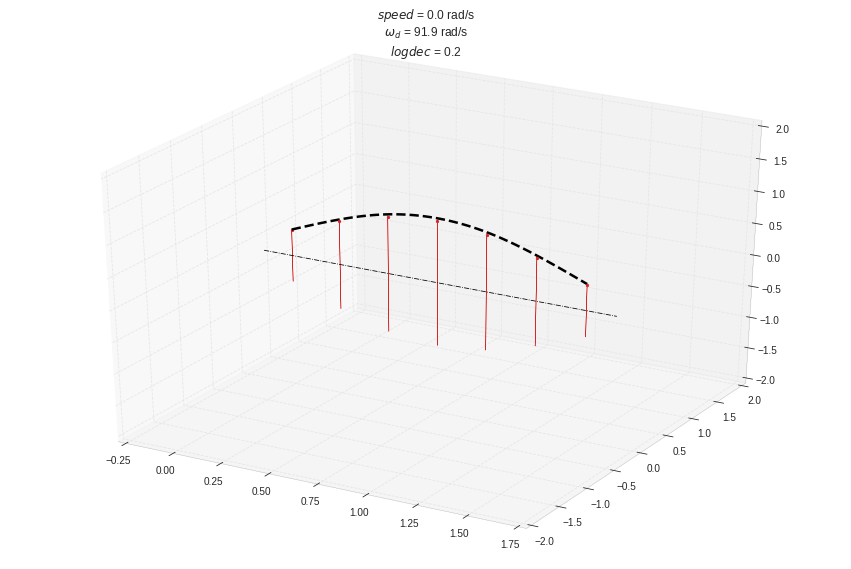

In [17]:
modes = rotor1.run_mode_shapes()
modes.plot(0)